# Experiment 1 Notebook

In this experiment we build a machine learning model around the diabetes_v1 csv file. In this version of the dataset we have eliminated the records with missing data as well as the outliers reducing the amount of records by a half.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from helpers import MultiplePlotMaker, StatAnalysisTools, ModelEvaluation
import numpy as np

In [2]:
df = pd.read_csv('dataset/diabetes_v1.csv').drop(columns=['index'])
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
1,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
2,5,166.0,72.0,19.0,175.0,25.8,0.587,51,1
3,0,118.0,84.0,47.0,230.0,45.8,0.551,31,1
4,1,115.0,70.0,30.0,96.0,34.6,0.529,32,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               321 non-null    int64  
 1   Glucose                   321 non-null    float64
 2   BloodPressure             321 non-null    float64
 3   SkinThickness             321 non-null    float64
 4   Insulin                   321 non-null    float64
 5   BMI                       321 non-null    float64
 6   DiabetesPedigreeFunction  321 non-null    float64
 7   Age                       321 non-null    int64  
 8   Outcome                   321 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 22.7 KB


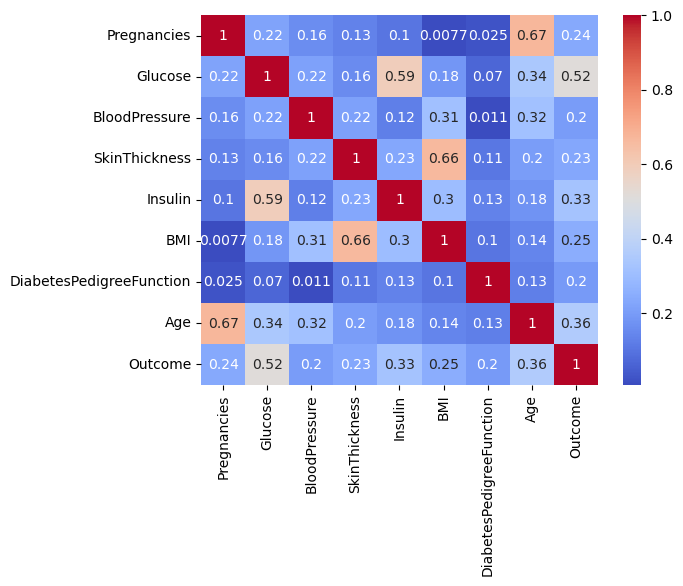

In [4]:
# Correlation matrix
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

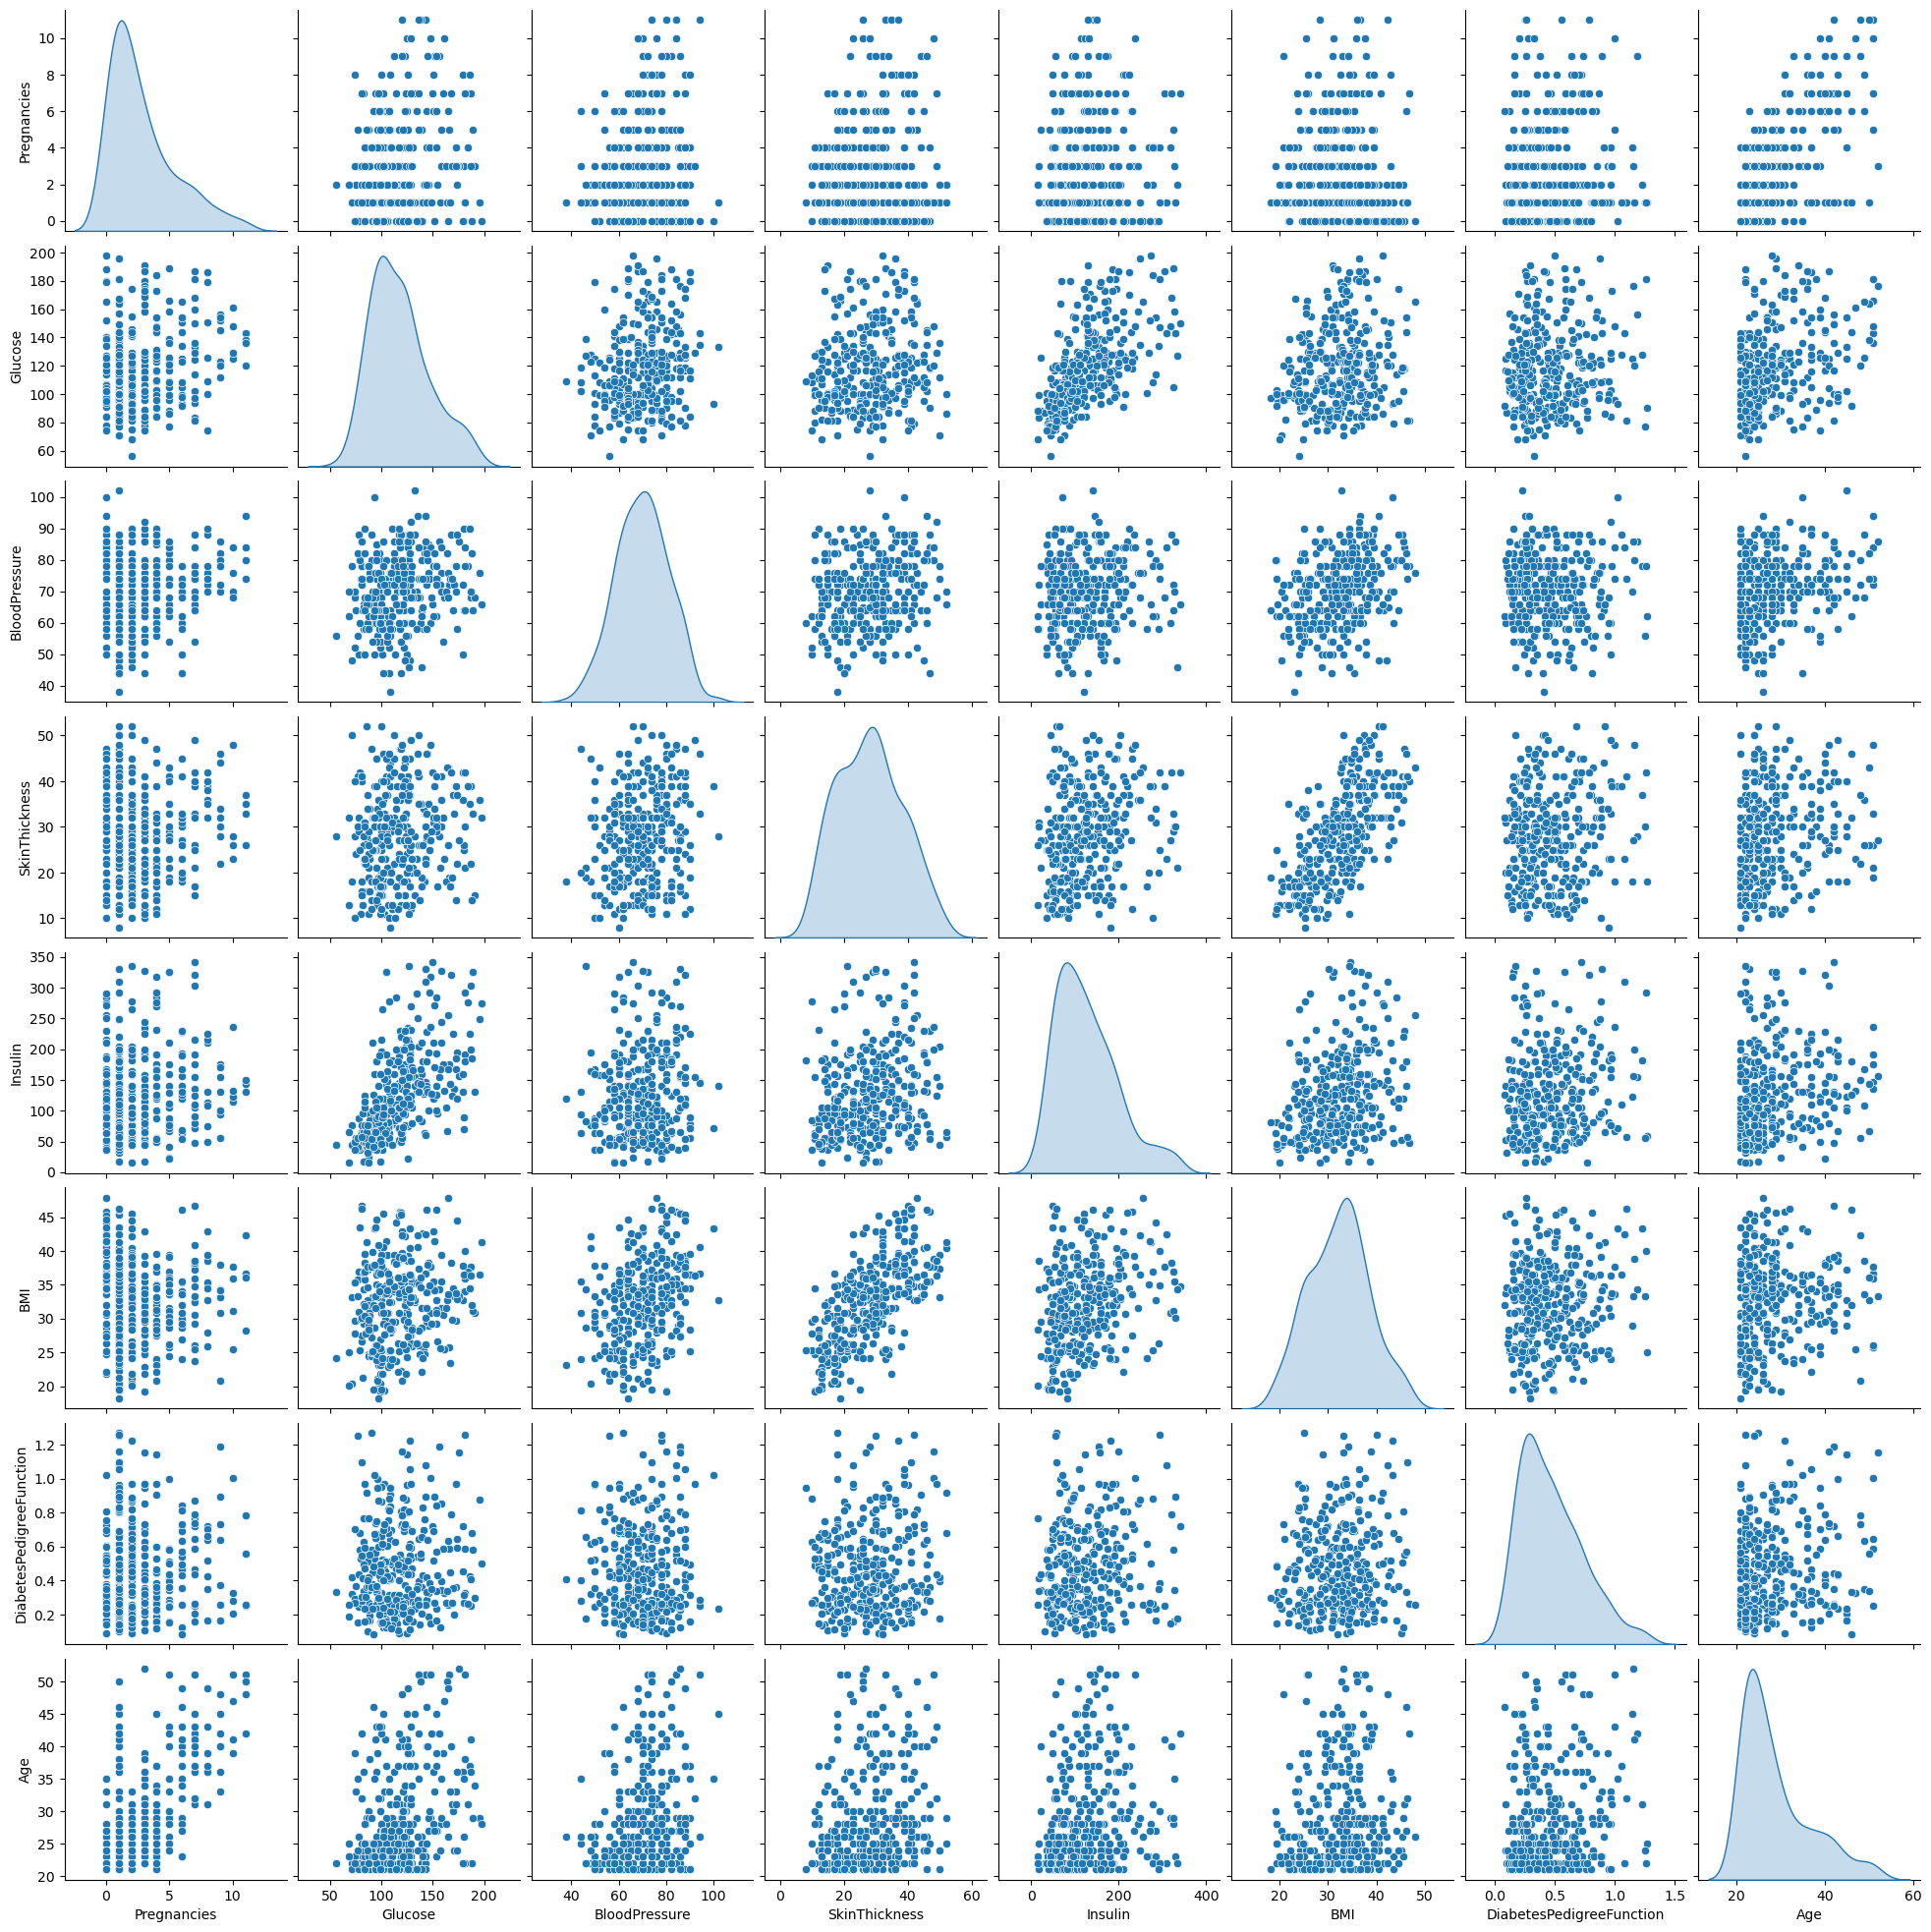

In [5]:
# List of columns to compare pairwise
columns_to_compare = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                      'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Create pairplot
sns.pairplot(df[columns_to_compare], diag_kind='kde')  # kde gives smoother diagonal plots

plt.show()

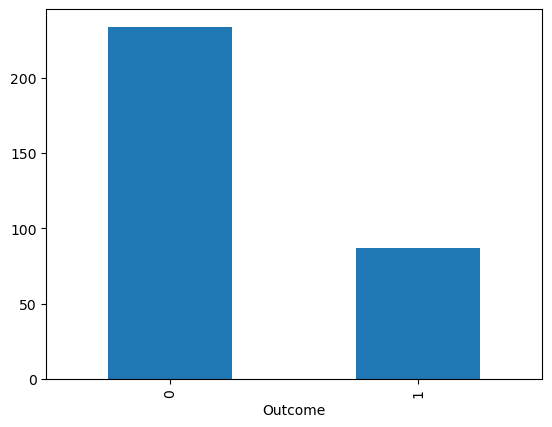

In [6]:
# Showing the class imbalance in our targer variable
df['Outcome'].value_counts().plot(kind='bar')
plt.show()


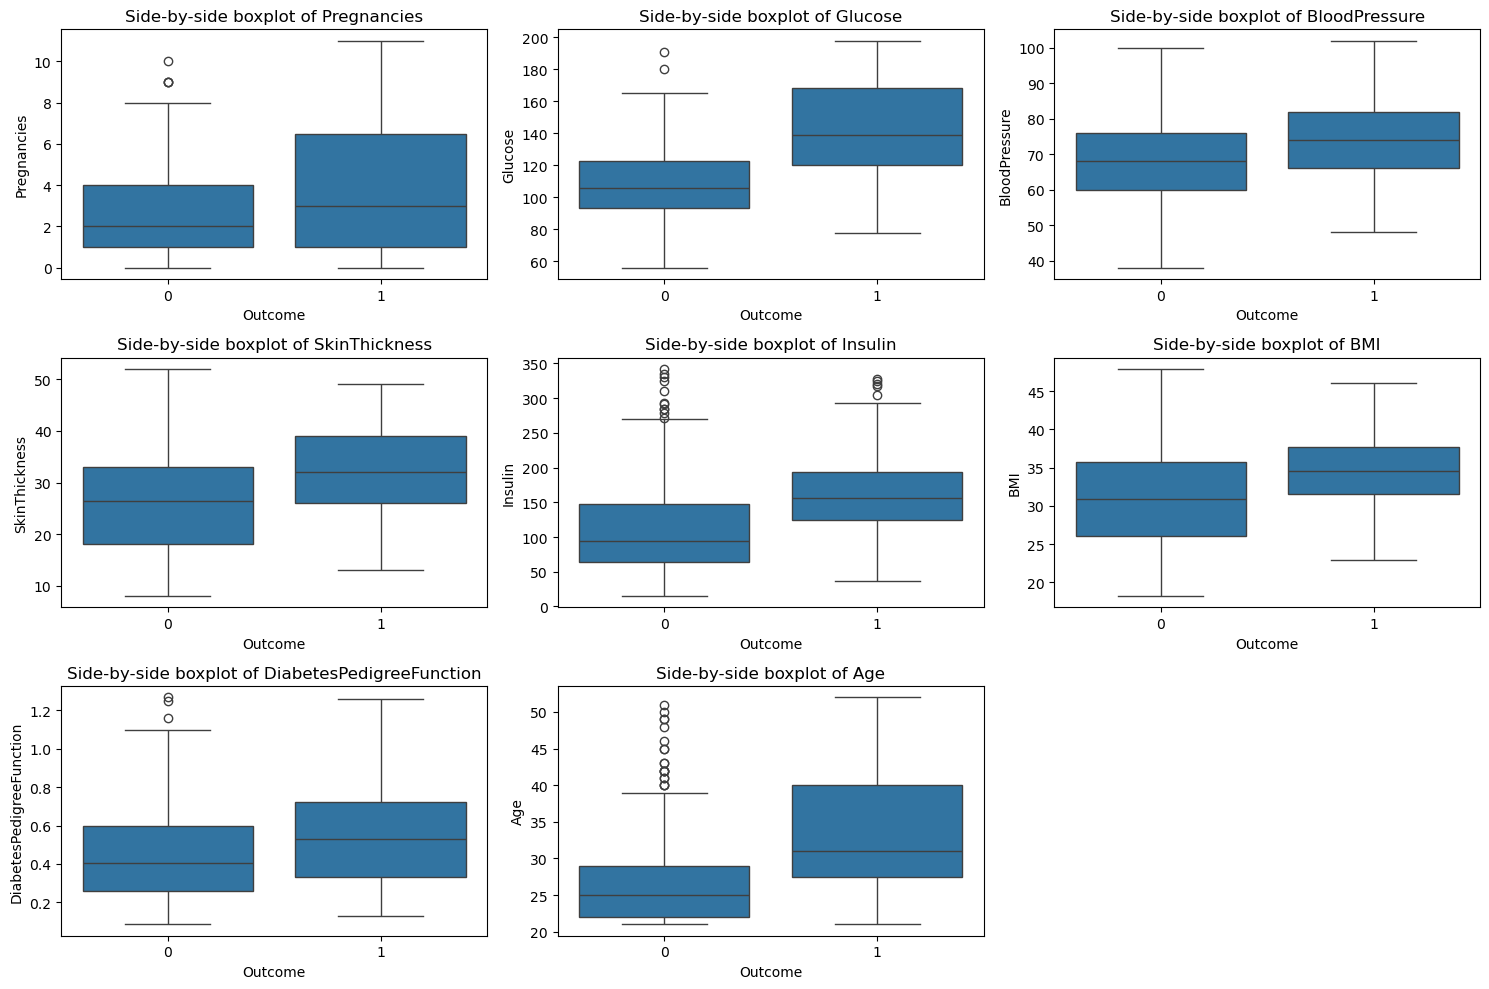

In [7]:
# Side by side boxplots to analyze associations between people with diabetes and wihtout diabetes
make_plots = MultiplePlotMaker(df=df)
make_plots.plot_multiple_side_by_side_boxplots()


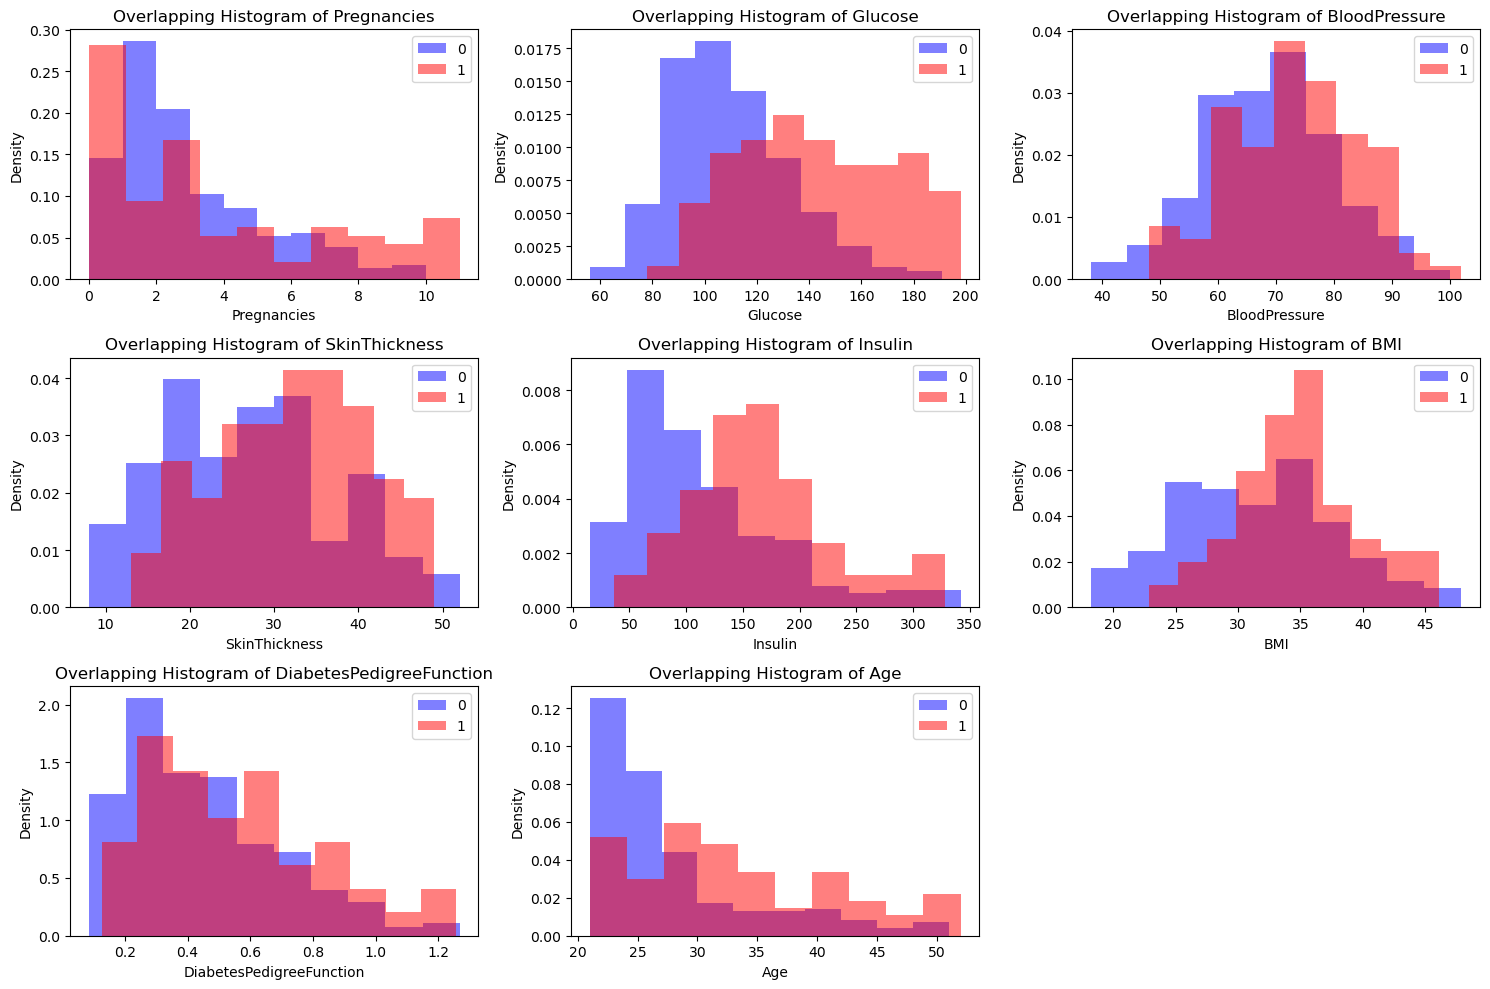

In [8]:
# Overlapping histograms to analyze associations between people with diabetes and wihtout diabetes
make_plots.plot_multiple_overlapping_hist()

In [9]:
# Perform numeric analysis to assess feature importance
stat_analysis = StatAnalysisTools(df=df)
stat_analysis.perform_t_test()

Pregnancies: t_stat = -4.355208437759099,  p-value = 1.793770533104499e-05
Glucose: t_stat = -10.738446541139526,  p-value = 3.6213039358613955e-23
BloodPressure: t_stat = -3.6163626559134077,  p-value = 0.00034715715602560824
SkinThickness: t_stat = -4.25063832750703,  p-value = 2.802357672365253e-05
Insulin: t_stat = -6.141077998425813,  p-value = 2.435659639745622e-09
BMI: t_stat = -4.6321000389395115,  p-value = 5.2792104724308756e-06
DiabetesPedigreeFunction: t_stat = -3.585353109827721,  p-value = 0.00038930588971085984
Age: t_stat = -6.89472649683236,  p-value = 2.8998132316142964e-11


In [10]:
stat_analysis.perform_correlation_binary_target()

Pregnancies: correlation = 0.23690337973006287, p-value = 1.793770533104515e-05
Glucose: correlation = 0.5152754223161857, p-value = 3.621303935861354e-23
BloodPressure: correlation = 0.19845035125463087, p-value = 0.000347157156025599
SkinThickness: correlation = 0.2315236920197748, p-value = 2.8023576723653103e-05
Insulin: correlation = 0.3251511115080269, p-value = 2.435659639745656e-09
BMI: correlation = 0.2510424763928625, p-value = 5.279210472431371e-06
DiabetesPedigreeFunction: correlation = 0.1968148713618482, p-value = 0.0003893058897108595
Age: correlation = 0.3601289065810265, p-value = 2.8998132316143358e-11


### Feature Importance / Association with Target Variable

#### Very Strong Association
- Glucose
- Insuline
- Age

#### Moderate to Strong Association
- Pregnancies
- SkinThickness
- BMI

#### Weak Association
- BloodPressure
- DiabetesPedigreeFunction

#### Comments
We can train the model with all the features and then eliminate the ones with weak associaitons and see if the model performance is the same or better.

## Data Preprocessing

In [44]:
# Split train and test sets
y = df['Outcome']
# X = df.drop(columns='Outcome')
X = df.drop(columns=['Outcome', 'BloodPressure', 'DiabetesPedigreeFunction'])

scaler_type = RobustScaler()


# Metadata for results csv
selected_features = 'Without BP and DPF'
scaler_name = 'RobustScaler'
results_file_path = 'experiment_results/experiment_1.csv'

In [45]:
estimator_pipelines = {
    'Logistic Regression': Pipeline([
        ('scaler', scaler_type),
        ('smote', SMOTE()),
        ('classifier', LogisticRegression(random_state=42))
    ]),
    'KNN': Pipeline([
        ('scaler', scaler_type),
        ('smote', SMOTE()),
        ('classifier', KNeighborsClassifier())
    ]),
    'Random Forest': Pipeline([
        ('scaler', scaler_type),
        ('smote', SMOTE()),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
}

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
scorer = make_scorer(f1_score)

for estimetor_name, estimator_pipeline in estimator_pipelines.items():
    scores = cross_val_score(estimator_pipeline, X, y, scoring=scorer, cv=cv)
    print(f'{estimetor_name} F1-score: {scores.mean():.3f} ± {scores.std():.3f}')

Logistic Regression F1-score: 0.661 ± 0.076
KNN F1-score: 0.622 ± 0.064
Random Forest F1-score: 0.601 ± 0.069


In [46]:
# Hyperparameter Tunning to check if we can get higher F1 scores

# Logistic Regression hyperparameters
logreg_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2', 'l1'],  # Note: 'l1' is supported only by 'liblinear' and 'saga'
    'classifier__solver': ['liblinear', 'saga']
}

# KNN hyperparameters
knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

# Random Forest hyperparameters
rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

# GridSearchCV for Logistic Regression
logreg_grid_search = GridSearchCV(
    estimator_pipelines['Logistic Regression'], 
    param_grid=logreg_param_grid, 
    cv=cv, 
    scoring=scorer,
    n_jobs=-1
)

# GridSearchCV for KNN
knn_grid_search = GridSearchCV(
    estimator_pipelines['KNN'], 
    param_grid=knn_param_grid, 
    cv=cv, 
    scoring=scorer,
    n_jobs=-1
)

# GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(
    estimator_pipelines['Random Forest'], 
    param_grid=rf_param_grid, 
    cv=cv, 
    scoring=scorer,
    n_jobs=-1
)

In [47]:
model_evaluation = ModelEvaluation()

In [48]:
# Run GridSearchCV for KNN
knn_grid_search.fit(X, y)
print(f"Best KNN parameters: {knn_grid_search.best_params_}")
print(f"Best KNN F1-score: {knn_grid_search.best_score_:.3f}")
print('=' * 20)

Best KNN parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}
Best KNN F1-score: 0.646


In [49]:
# Run GridSearchCV for Random Forest
rf_grid_search.fit(X, y)
print(f"Best RF parameters: {rf_grid_search.best_params_}")
print(f"Best RF F1-score: {rf_grid_search.best_score_:.3f}")
print('=' * 20)

Best RF parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
Best RF F1-score: 0.632


In [50]:
# Run GridSearchCV for Logistic Regression
logreg_grid_search.fit(X, y)
print(f"Best Logistic Regression parameters: {logreg_grid_search.best_params_}")
print(f"Best Logistic Regression F1-score: {logreg_grid_search.best_score_:.3f}")
print('=' * 20)

Best Logistic Regression parameters: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best Logistic Regression F1-score: 0.642


Accuracy: 0.908
Precision: 0.833
Recall: 0.833
F1-Score: 0.833
ROC-AUC Score: 0.968
Confusion Matrix:
[[44  3]
 [ 3 15]]


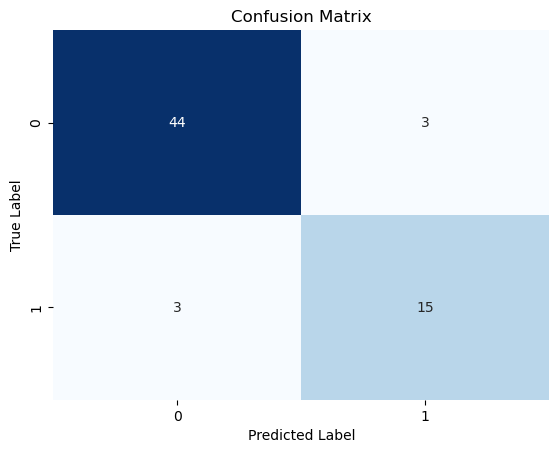

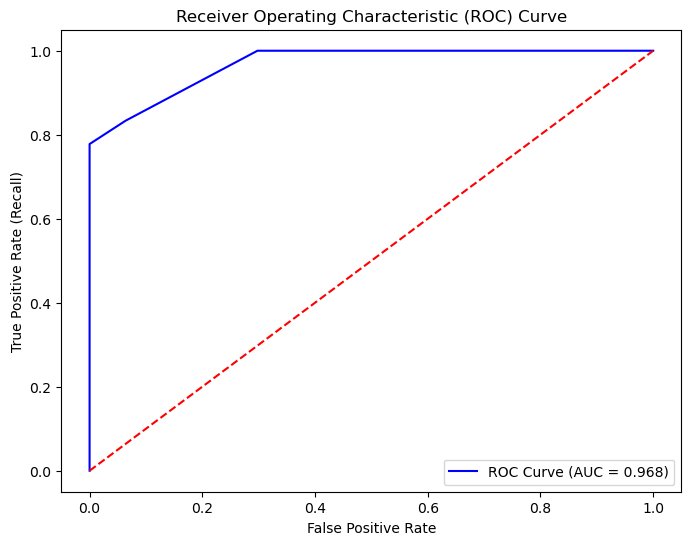

In [51]:
model_evaluation.evaluate_classifier(X, y, knn_grid_search.best_estimator_, scaler_name=scaler_name, selected_features=selected_features, csv_file_path=results_file_path)

Accuracy: 0.969
Precision: 1.000
Recall: 0.889
F1-Score: 0.941
ROC-AUC Score: 0.995
Confusion Matrix:
[[47  0]
 [ 2 16]]


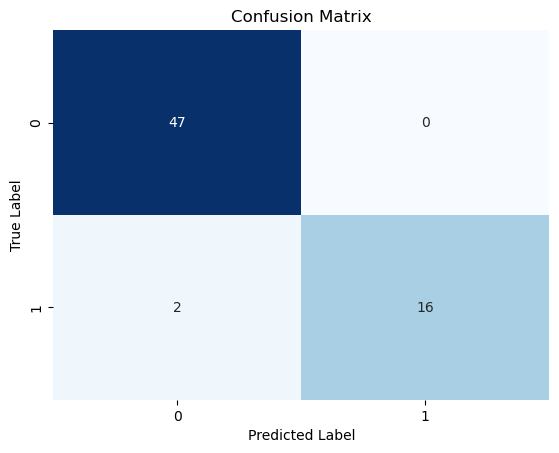

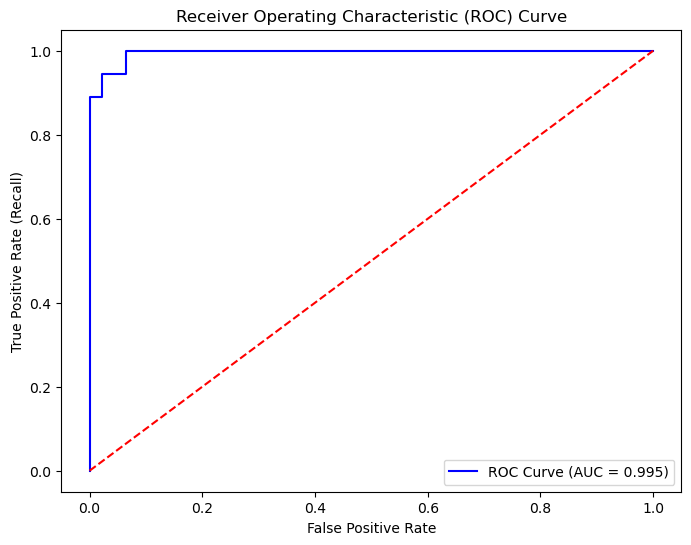

In [52]:
model_evaluation.evaluate_classifier(X, y, rf_grid_search.best_estimator_, scaler_name=scaler_name, selected_features=selected_features, csv_file_path=results_file_path)

Accuracy: 0.723
Precision: 0.500
Recall: 0.667
F1-Score: 0.571
ROC-AUC Score: 0.788
Confusion Matrix:
[[35 12]
 [ 6 12]]


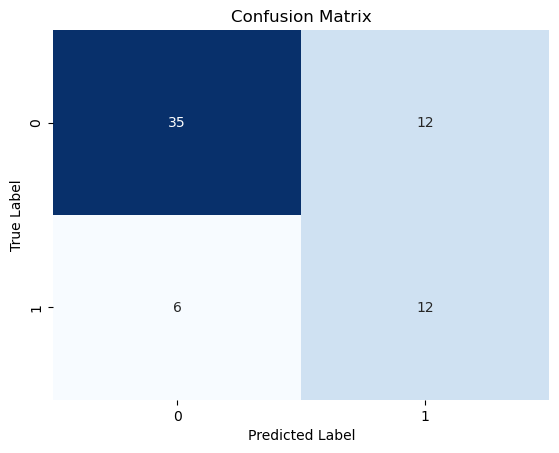

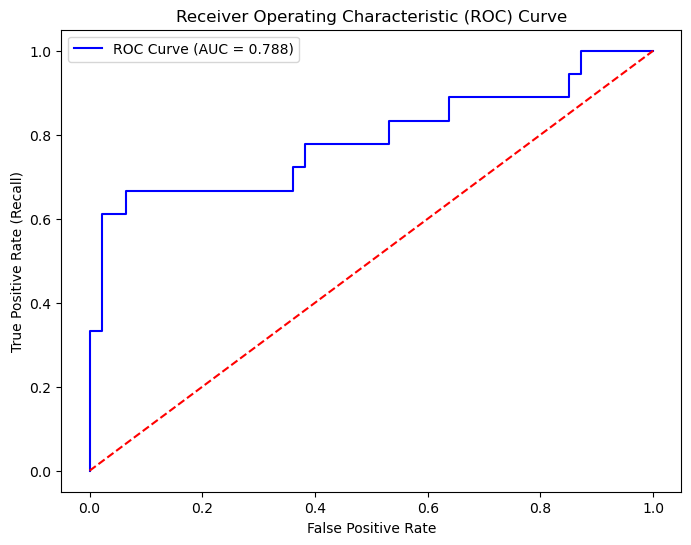

In [53]:
model_evaluation.evaluate_classifier(X, y, logreg_grid_search.best_estimator_, scaler_name=scaler_name, selected_features=selected_features, csv_file_path=results_file_path)

In [54]:
# Results
results_df = pd.read_csv('experiment_results/experiment_1.csv')
results_df.sort_values(by='f1_score', ascending=False)

,scaler_name,selected_features,accuracy,precision,recall,f1_score,roc_auc
0,StandarScaler,All Features,1.000000,1.000000,1.000000,1.000000,1.000000
6,StandardScaler,Without BP and DPF,1.000000,1.000000,1.000000,1.000000,1.000000
7,StandardScaler,Without BP and DPF,1.000000,1.000000,1.000000,1.000000,1.000000
1,StandarScaler,All Features,0.984615,1.000000,0.944444,0.971429,0.997636
10,RobustScaler,Without BP and DPF,0.969231,1.000000,0.888889,0.941176,0.995272
4,RobustScaler,All Features,0.953846,1.000000,0.833333,0.909091,0.991726
9,RobustScaler,Without BP and DPF,0.907692,0.833333,0.833333,0.833333,0.968085
3,RobustScaler,All Features,0.738462,0.518519,0.777778,0.622222,0.864657
5,RobustScaler,All Features,0.753846,0.545455,0.666667,0.600000,0.795508
2,StandarScaler,All Features,0.723077,0.500000,0.666667,0.571429,0.790780
